In [157]:
import vk, vk_api
import pandas as pd
import time
import random
import requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from dataclasses import dataclass
from clickhouse_driver import Client as CHClient
import datetime

## Task 1

In [145]:
# https://vkhost.github.io/

vk_id = 101180492
access_token = 'vk1.a.Y8Zq27xTeA8qn-AIul451WZ_XHdyiWRXlZJfYgBaUgeBorO5DGKKNwxA3yAK6dT4ebYWkzUUFZovjLRtcRQ1FYZ26y5SMj3ECQfZrCajTsFwSgt-ruzbV9Ogl8ZMGgKW-cIICl5WGc_AQEjJeCoqNv3eWTYjb7bKdMzkn3gETP6gCKV_Du6sCWCkGXPQ7WfX'

In [146]:
vk_session = vk_api.VkApi(token=access_token)
vk = vk_session.get_api()

In [147]:
my_user = vk.users.get(user_id=vk_id, fields='id,about,bdate,city,country,followers_count')

In [148]:
my_user

[{'id': 101180492,
  'bdate': '13.11.2000',
  'city': {'id': 5058728, 'title': 'Gayville'},
  'country': {'id': 9, 'title': 'США'},
  'about': '',
  'followers_count': 321,
  'first_name': 'Александр',
  'last_name': 'Борискин',
  'can_access_closed': True,
  'is_closed': False}]

## Task 2

In [112]:
def get_friends(token, user_id, with_name = False):
    fields = 'first_name,last_name,city,country' if with_name else ''
    url = 'https://api.vk.com/method/friends.get?' + \
                        'access_token={}&user_id={}&fields={}&v=5.81'.format(token,user_id, fields)
    response = requests.get(url).json()
    if response.get('error'):
        print(response.get('error'))
        return []
    return response.get('response').get('items')

In [113]:
CENTRAL_USER_ID = vk_id

In [114]:
central_users = get_friends(access_token, CENTRAL_USER_ID)

In [115]:
central_users = get_friends(access_token, CENTRAL_USER_ID, with_name=True)
central_users = {user_dict['id']: user_dict.get('first_name') + \
                ' ' + user_dict.get('last_name') for user_dict in central_users}

central_users[CENTRAL_USER_ID] = 'Я'

In [116]:
graph = {}

for user_id in central_users.keys():
    graph[user_id] = get_friends(access_token, user_id)
    time.sleep(random.randint(1, 10) / 100)

{'error_code': 18, 'error_msg': 'User was deleted or banned', 'request_params': [{'key': 'user_id', 'value': '15165528'}, {'key': 'fields', 'value': ''}, {'key': 'v', 'value': '5.81'}, {'key': 'method', 'value': 'friends.get'}, {'key': 'oauth', 'value': '1'}]}
{'error_code': 18, 'error_msg': 'User was deleted or banned', 'request_params': [{'key': 'user_id', 'value': '271070576'}, {'key': 'fields', 'value': ''}, {'key': 'v', 'value': '5.81'}, {'key': 'method', 'value': 'friends.get'}, {'key': 'oauth', 'value': '1'}]}


In [117]:
uniqie_users = set(graph.keys())

In [118]:
for users_friends in graph.values():
    uniqie_users.update(users_friends)
print(len(users_friends))

212


In [119]:
g = nx.Graph()
for user_id, user_friends in graph.items():
    g.add_node(central_users[user_id])
    for friends_id in user_friends:
        if friends_id in central_users:
            g.add_edge(central_users[user_id], central_users[friends_id])

In [120]:
def graph_plot():
    plt.figure(figsize=(12, 9))
    nx.draw_kamada_kawai(g, with_labels=True, node_size=50, width=0.5)
    plt.show()

In [121]:
g.remove_node(central_users[CENTRAL_USER_ID])

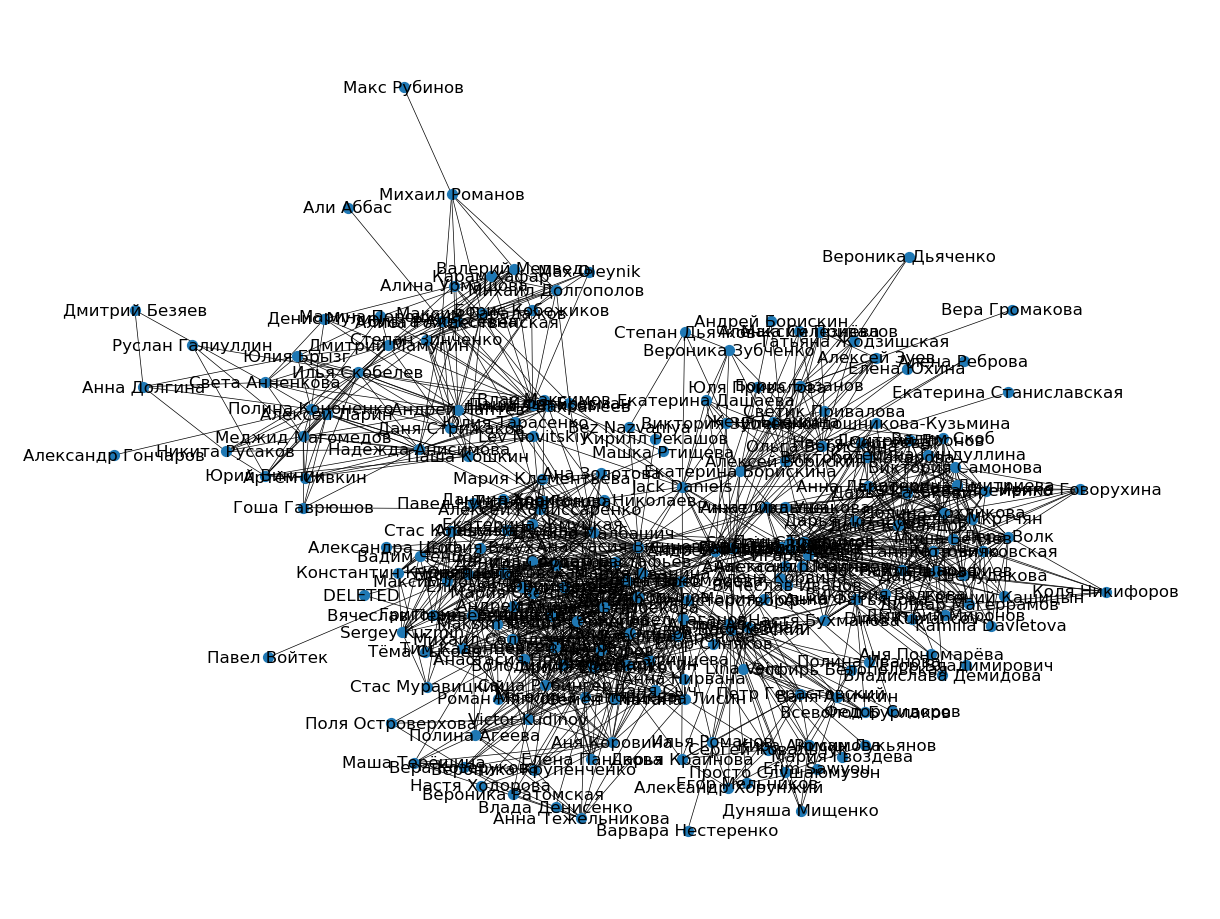

In [122]:
graph_plot()

Я вижу 4 кластера
1) слева сверху - друзья из мисис
2) кластер внизу - друзья из новой школы
3) кластер справа посередине - друзья из старой школы
4) кластер сверху справа - родственники и друзья родственников

In [125]:
my_friends = get_friends(access_token, CENTRAL_USER_ID, with_name=True)
cities = []
for friend in my_friends:
    if friend.get('city'):
        cities.append(friend['city']['title'])
                      
city_stats = dict(Counter(cities))
unique_cities = list(city_stats.keys())

In [126]:
API_KEY = '4317c62f-9957-45cf-b900-5dcaf3508aff'

In [129]:
@dataclass
class YandexGeocoder:
    api_key: str
    geocoder_url: str = 'https://geocode-maps.yandex.ru/1.x'

    def adress_to_geopoint(self, address: str) -> str:
        """
        Преобразование адреса в геокоординаты в формате Datalens
        """
        response = requests.get(self.geocoder_url, params={
            'apikey': self.api_key,
            'geocode': address,
            'format': 'json',
        })
        response.raise_for_status()

        result = response.json()['response']['GeoObjectCollection']['featureMember']
        if not result:
            return None

        lat, lon = result[0]['GeoObject']['Point']['pos'].split(' ')
        return self._to_datalens_format(lon, lat)
    
    def _to_datalens_format(self, lon, lat):
        return f'[{lon},{lat}]'

In [139]:
geocoder = YandexGeocoder(api_key=API_KEY)
lat_lon_cities = []

for adress in unique_cities:
    s = eval(geocoder.adress_to_geopoint(adress))
    lat_lon_cities.append(s)

In [141]:
friends_distribution = pd.DataFrame({
    'city': list(city_stats.keys()),
    'people': list(city_stats.values()),
    'x': [coord[0] for coord in encoded_data],
    'y': [coord[1] for coord in encoded_data]
})

In [142]:
friends_distribution.to_csv('friends.csv', index=False)

https://datalens.yandex/6cj9t6aej60mv

## Task 3

In [152]:
all_users = []
num_users = 0
birth_days = range(0, 31)
birth_months = range(0, 12)

for birth_month in birth_months:
    for birth_day in birth_days:
        users = vk.users.search(
            city=97, 
            fields='name,sex,bdate', 
            count=1000,
            birth_day=birth_day,
            birth_month=birth_month
        )
        num_users += users['count']
        all_users.extend(users['items'])

In [154]:
len(all_users)

266961

In [155]:
for user in all_users:
    if user.get('bdate') and len(user.get('bdate')) == 10:
        filtered_users.append((user['id'], user['first_name'], user['sex'], user['bdate']))

In [160]:
sampled_users = random.sample([
    (user[0], user[1], user[2], (datetime.datetime.now() - datetime.datetime.strptime(user[3], '%d.%m.%Y')).days // 365)
    for user in filtered_users], 10_000)

In [161]:
len(sampled_users)

10000

In [162]:
female_names = list(map(lambda x: x[1], filter(lambda x: x[2] == 1, sampled_users)))
male_names = list(map(lambda x: x[1], filter(lambda x: x[2] == 2, sampled_users)))
male_name_stats =  dict(sorted(list(dict(Counter(male_names)).items()), key=lambda x: x[1], reverse=True))
female_name_stats =  dict(sorted(list(dict(Counter(female_names)).items()), key=lambda x: x[1], reverse=True))

In [168]:
names_data = pd.DataFrame(
    sampled_users, columns=["id", "name", "sex", "age"]
).drop(labels=["id",], axis=1).groupby(["sex", "age"]).agg("count").reset_index()

In [172]:
names_data = names_data[names_data['sex'].isin([1, 2])]

In [173]:
names_data.to_csv("names_data.csv", index=False)

В настройках поля:
IF 
    [sex] = 2
    THEN [name]*(-1)
ELSE
    [name]
END

https://datalens.yandex/qw4ielnhjenmf